<a href="https://colab.research.google.com/github/bloyal/Deep-Learning-with-Python/blob/main/Deep_Learning_with_Python_Chapter_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10.2 A temperature forecasting example

In [1]:
# Download the weather data recorded at the Max Planck Institute for 
# Biogeochemistry from 2009-2016

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2021-08-09 19:51:02--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.29.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.29.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  16.2MB/s    in 0.8s    

2021-08-09 19:51:03 (16.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
# Listing 10.1 Inspecting the data of the Jena weather dataset
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
# Listing 10.2 Parsing the data into a np array for temp (The predictor) and
# another for the other features
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

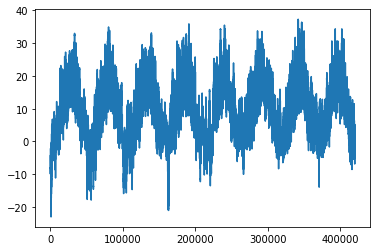

In [4]:
# Listing 10.3 Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

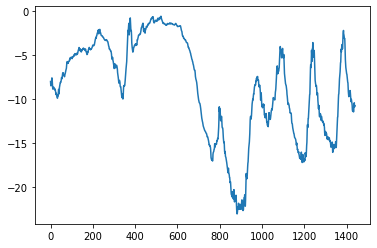

In [5]:
# Listing 10.4 Plotting only the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440])

In [6]:
# Listing 10.5 Computing the number of samples we'll use for each data split
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = int(len(raw_data) - num_train_samples - num_val_samples)

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
# Listing 10.6 Normalizing the data (only on first 210,225 records)
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
# Understanding timeseries_dataset_from_array
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
# Listing 10.7 Instantiating Datasets for training, validation ,and testing
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
train_dataset

<BatchDataset shapes: ((None, None, 14), (None,)), types: (tf.float64, tf.float64)>

In [11]:
# Listing 10.8 inspecting the output of one of our datasets
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break


samples shape (256, 120, 14)
targets shape (256,)


## 10.2.2 A common-sense, non-ML baseline

In [20]:
# Listing 10.9 Compute a common-sense baseline MAE where you predict the temp
# 24-hours from now to be the same as the current temp

def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## 10.2.3 A Basic ML Model

In [16]:
# Listing 10.10 Training and evaluating a densely connected model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 41s 46ms/step - loss: 12.9963 - mae: 2.7884 - val_loss: 12.6716 - val_mae: 2.8095
Epoch 2/10
819/819 [==============================] - 39s 48ms/step - loss: 9.1290 - mae: 2.3796 - val_loss: 11.4151 - val_mae: 2.6757
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 8.3684 - mae: 2.2784 - val_loss: 10.6447 - val_mae: 2.5861
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 7.9444 - mae: 2.2178 - val_loss: 11.5959 - val_mae: 2.6861
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 7.5871 - mae: 2.1673 - val_loss: 11.7535 - val_mae: 2.7271
Epoch 6/10
819/819 [==============================] - 39s 47ms/step - loss: 7.3229 - mae: 2.1305 - val_loss: 12.1682 - val_mae: 2.7608
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 7.1234 - mae: 2.1025 - val_loss: 11.7955 - val_mae: 2.7245
Epoch 8/10
819/819 [==============================] - 

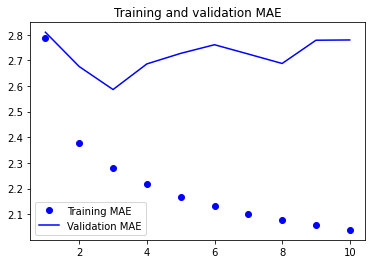

In [17]:
# Listing 10.11 Plotting loss curves
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 10.2.4 Let's try a 1D convolutional model

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 68s 48ms/step - loss: 30.2254 - mae: 4.1547 - val_loss: 16.4316 - val_mae: 3.1927
Epoch 2/10
819/819 [==============================] - 40s 48ms/step - loss: 16.5101 - mae: 3.2281 - val_loss: 16.4311 - val_mae: 3.1522
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 15.2168 - mae: 3.0962 - val_loss: 20.7625 - val_mae: 3.6679
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 14.5177 - mae: 3.0235 - val_loss: 15.9913 - val_mae: 3.1578
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 13.8909 - mae: 2.9543 - val_loss: 14.5303 - val_mae: 2.9910
Epoch 6/10
819/819 [==============================] - 42s 50ms/step - loss: 13.4159 - mae: 2.9032 - val_loss: 18.5979 - val_mae: 3.4125
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 12.9893 - mae: 2.8548 - val_loss: 16.4330 - val_mae: 3.2329
Epoch 8/10
819/819 [============================

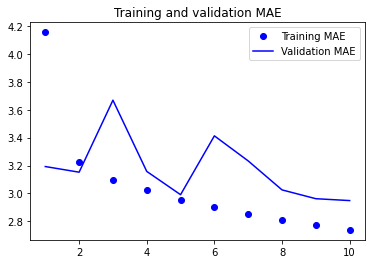

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 10.2.5 A first recurrent baseline

In [21]:
# Listing 10.12 A simple LTSM-based model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")


Epoch 1/10
819/819 [==============================] - 47s 54ms/step - loss: 39.6266 - mae: 4.5685 - val_loss: 12.4776 - val_mae: 2.6833
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 11.0192 - mae: 2.5733 - val_loss: 9.8320 - val_mae: 2.4430
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 9.8009 - mae: 2.4362 - val_loss: 9.4286 - val_mae: 2.3967
Epoch 4/10
819/819 [==============================] - 45s 54ms/step - loss: 9.3390 - mae: 2.3811 - val_loss: 9.3448 - val_mae: 2.3780
Epoch 5/10
819/819 [==============================] - 45s 54ms/step - loss: 8.9412 - mae: 2.3324 - val_loss: 9.3409 - val_mae: 2.3796
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 8.6702 - mae: 2.2991 - val_loss: 9.3537 - val_mae: 2.3813
Epoch 7/10
819/819 [==============================] - 44s 54ms/step - loss: 8.4538 - mae: 2.2717 - val_loss: 9.1439 - val_mae: 2.3620
Epoch 8/10
819/819 [==============================] - 45s 5

In [22]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 35ms/step - loss: 10.5532 - mae: 2.5492
Test MAE: 2.55


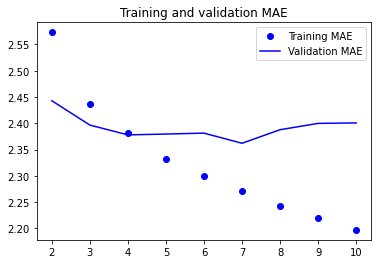

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(2, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss[1:], "bo", label="Training MAE")
plt.plot(epochs, val_loss[1:], "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Understanding recurrent neural networks

In [30]:
# Listing 10.5 NumPy-based simple RNN

import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

In [32]:
final_output_sequence.shape

(6400,)

## 10.3.1 A recurrent layuer in Keras

In [35]:
# Listing 10.17 A RNN layer that returns only its last output step
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = keras.layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [36]:
# Listing 10.18 Example that returns the full state sequence
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


# 10.4 Advanced use of RNNs

In [39]:
# Listing 10.22 Training and evaluating a dropout-regularized LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25, unroll=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 152s 141ms/step - loss: 27.7228 - mae: 3.8861 - val_loss: 9.6196 - val_mae: 2.4068


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f142f418c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 2/50
 19/819 [..............................] - ETA: 1:31 - loss: 15.9701 - mae: 3.0962

KeyboardInterrupt: ignored

In [40]:
# Listing 10.23 Training and evaluating a dropout-regularized, stacked GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
 45/819 [>.............................] - ETA: 8:07 - loss: 98.8266 - mae: 8.0806

KeyboardInterrupt: ignored

In [41]:
# Listing 10.24 Training and evaluating a bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 54s 63ms/step - loss: 28.8695 - mae: 3.8348 - val_loss: 10.3490 - val_mae: 2.4818
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 9.5833 - mae: 2.4147 - val_loss: 10.0940 - val_mae: 2.4460
Epoch 3/10
819/819 [==============================] - 51s 62ms/step - loss: 8.7329 - mae: 2.3074 - val_loss: 10.6533 - val_mae: 2.4893
Epoch 4/10
 54/819 [>.............................] - ETA: 39s - loss: 8.5947 - mae: 2.2881

KeyboardInterrupt: ignored